In [1]:
# From https://www.kaggle.com/carlossouza/osic-autoencoder-training
import sys, os
if os.path.abspath(os.pardir) not in sys.path:
    sys.path.insert(0, os.path.abspath(os.pardir))
import CONFIG
%reload_ext autoreload
%autoreload 2

In [2]:
import copy
from datetime import timedelta, datetime
import imageio
import matplotlib.pyplot as plt
from matplotlib import cm
import multiprocessing
import numpy as np
import os
from pathlib import Path
import pydicom
import pytest
import scipy.ndimage as ndimage
from scipy.ndimage.interpolation import zoom
from skimage import measure, morphology, segmentation
from time import time, sleep
from tqdm import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import warnings

In [3]:
root_dir = CONFIG.CFG.DATA.BASE
test_dir = os.path.join(root_dir, "test")
model_file = "model.pt"
resize_dims = (40, 256, 256)
clip_bounds = (-1000, 200)
watershed_iterations = 1
pre_calculated_mean = 0.02865046213070556
latent_features = 10
batch_size = 16
learning_rate = 3e-5
num_epochs = 10
val_size = 0.2
tensorboard_dir = "runs"

In [5]:
class CTScansDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.patients = [p for p in self.root_dir.glob('*') if p.is_dir()]
        self.transform = transform

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image, metadata = self.load_scan(self.patients[idx])
        sample = {
            'image': image,
            'metadata': metadata
        }
        if self.transform:
            sample = self.transform(sample)

        return sample

    def save(self, path):
        t0 = time()
        Path(path).mkdir(exist_ok=True, parents=True)
        print("Saving pre-procssed dataset to disk")
        sleep(1)
        cum = 0

        bar = trange(len(self))
        for i in bar:
            sample = self[i]
            image, data = sample['image'], sample['metadata']
            cum += torch.mean(image).item()

            bar.set_description(f'Saving CT scan {data.PatientID}')
            fname = Path(path) / f'{data.PatientID}.pt'
            torch.save(image, fname)

        sleep(1)
        bar.close()

        print(f'Done! Time {timedelta(seconds=time() - t0)})\n',
              f'Mean value: {cum / len(self)}')

    def get_patient(self, patient_id):
        patient_ids = [str(p.stem) for p in self.patients]
        return self.__getitem__(patient_ids.index(patient_id))

    @staticmethod
    def load_scan(path):
        slices = [pydicom.read_file(p) for p in path.glob('*.dcm')]
        try:
            slices.sort(key=lambda x: float(x.ImagePosition[2]))
        except AttributeError:
            warnings.warn('f {slices[0].PatientID} CT scan does not '
                        f'have "ImagePosition". Assuming filenames are in the right scan order')
        image = np.stack([s.pixel_array.astype(float) for s in slices])
        return image, slices[0]

In [6]:
class CropBoundingBox:
    @staticmethod
    def bounding_box(img3d: np.array):
        mid_img = img3d[int(img3d.shape[0] / 2)]
        same_first_row = (mid_img[0, :] == mid_img[0, 0]).all()
        same_first_col = (mid_img[:, 0] == mid_img[0, 0]).all()
        if same_first_col and same_first_row:
            return True
        else:
            return False

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        if not self.bounding_box(image):
            return sample

        mid_img = image[int(image.shape[0] / 2)]
        r_min, r_max = None, None
        c_min, c_max = None, None
        for row in range(mid_img.shape[0]):
            if not (mid_img[row, :] == mid_img[0, 0]).all() and r_min is None:
                r_min = row
            if (mid_img[row, :] == mid_img[0, 0]).all() and r_max is None \
                    and r_min is not None:
                r_max = row
                break

        for col in range(mid_img.shape[1]):
            if not (mid_img[:, col] == mid_img[0, 0]).all() and c_min is None:
                c_min = col
            if (mid_img[:, col] == mid_img[0, 0]).all() and c_max is None \
                    and c_min is not None:
                c_max = col
                break

        image = image[:, r_min:r_max, c_min:c_max]
        return {'image': image, 'metadata': data}

In [7]:
class ConvertToHU:
    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']

        img_type = data.ImageType
        is_hu = img_type[0] == 'ORIGINAL' and not (img_type[2] == 'LOCALIZER')
        # if not is_hu:
        #     warnings.warn(f'Patient {data.PatientID} CT Scan not cannot be'
        #                   f'converted to Hounsfield Units (HU).')

        intercept = data.RescaleIntercept
        slope = data.RescaleSlope
        image = (image * slope + intercept).astype(np.int16)
        return {'image': image, 'metadata': data}

In [8]:
class Resize:
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        resize_factor = np.array(self.output_size) / np.array(image.shape)
        image = zoom(image, resize_factor, mode='nearest')
        return {'image': image, 'metadata': data}

In [9]:
class Clip:
    def __init__(self, bounds=(-1000, 500)):
        self.min = min(bounds)
        self.max = max(bounds)

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        image[image < self.min] = self.min
        image[image > self.max] = self.max
        return {'image': image, 'metadata': data}

In [10]:
class MaskWatershed:
    def __init__(self, min_hu, iterations, show_tqdm):
        self.min_hu = min_hu
        self.iterations = iterations
        self.show_tqdm = show_tqdm

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']

        stack = []
        if self.show_tqdm:
            bar = trange(image.shape[0])
            bar.set_description(f'Masking CT scan {data.PatientID}')
        else:
            bar = range(image.shape[0])
        for slice_idx in bar:
            sliced = image[slice_idx]
            stack.append(self.seperate_lungs(sliced, self.min_hu,
                                             self.iterations))

        return {
            'image': np.stack(stack),
            'metadata': sample['metadata']
        }

    @staticmethod
    def seperate_lungs(image, min_hu, iterations):
        h, w = image.shape[0], image.shape[1]

        marker_internal, marker_external, marker_watershed = MaskWatershed.generate_markers(image)

        # Sobel-Gradient
        sobel_filtered_dx = ndimage.sobel(image, 1)
        sobel_filtered_dy = ndimage.sobel(image, 0)
        sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
        sobel_gradient *= 255.0 / np.max(sobel_gradient)

        watershed = morphology.watershed(sobel_gradient, marker_watershed)

        outline = ndimage.morphological_gradient(watershed, size=(3,3))
        outline = outline.astype(bool)

        # Structuring element used for the filter
        blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                           [0, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1],
                           [0, 1, 1, 1, 1, 1, 0],
                           [0, 0, 1, 1, 1, 0, 0]]

        blackhat_struct = ndimage.iterate_structure(blackhat_struct, iterations)

        # Perform Black Top-hat filter
        outline += ndimage.black_tophat(outline, structure=blackhat_struct)

        lungfilter = np.bitwise_or(marker_internal, outline)
        lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)

        segmented = np.where(lungfilter == 1, image, min_hu * np.ones((h, w)))

        return segmented  #, lungfilter, outline, watershed, sobel_gradient

    @staticmethod
    def generate_markers(image, threshold=-400):
        h, w = image.shape[0], image.shape[1]

        marker_internal = image < threshold
        marker_internal = segmentation.clear_border(marker_internal)
        marker_internal_labels = measure.label(marker_internal)

        areas = [r.area for r in measure.regionprops(marker_internal_labels)]
        areas.sort()

        if len(areas) > 2:
            for region in measure.regionprops(marker_internal_labels):
                if region.area < areas[-2]:
                    for coordinates in region.coords:
                        marker_internal_labels[coordinates[0], coordinates[1]] = 0

        marker_internal = marker_internal_labels > 0

        # Creation of the External Marker
        external_a = ndimage.binary_dilation(marker_internal, iterations=10)
        external_b = ndimage.binary_dilation(marker_internal, iterations=55)
        marker_external = external_b ^ external_a

        # Creation of the Watershed Marker
        marker_watershed = np.zeros((h, w), dtype=np.int)
        marker_watershed += marker_internal * 255
        marker_watershed += marker_external * 128

        return marker_internal, marker_external, marker_watershed

In [11]:
class Normalize:
    def __init__(self, bounds=(-1000, 500)):
        self.min = min(bounds)
        self.max = max(bounds)

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        image = image.astype(np.float)
        image = (image - self.min) / (self.max - self.min)
        return {'image': image, 'metadata': data}
    

class ToTensor:
    def __init__(self, add_channel=True):
        self.add_channel = add_channel

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        if self.add_channel:
            image = np.expand_dims(image, axis=0)

        return {'image': torch.from_numpy(image), 'metadata': data}
    
    
class ZeroCenter:
    def __init__(self, pre_calculated_mean):
        self.pre_calculated_mean = pre_calculated_mean

    def __call__(self, tensor):
        return tensor - self.pre_calculated_mean

In [12]:
def show(list_imgs, cmap=cm.bone):
    list_slices = []
    for img3d in list_imgs:
        slc = int(img3d.shape[0] / 2)
        img = img3d[slc]
        list_slices.append(img)
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 7))
    for i, img in enumerate(list_slices):
        axs[i].imshow(img, cmap=cmap)
        axs[i].axis('off')
        
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: f {slices[0].PatientID} CT scan does not have "ImagePosition". Assuming filenames are in the right scan order
Masking CT scan ID00422637202311677017371: 100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


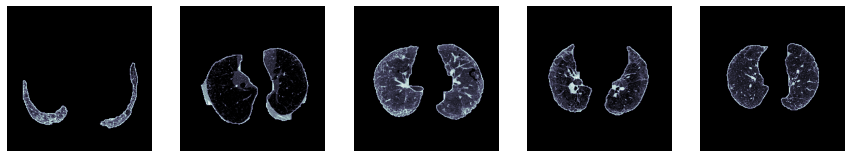

In [13]:
test = CTScansDataset(
    root_dir=test_dir,
    transform=transforms.Compose([
        CropBoundingBox(),
        ConvertToHU(),
        Resize(resize_dims),
        Clip(bounds=clip_bounds),
        MaskWatershed(min_hu=min(clip_bounds), iterations=1, show_tqdm=True),
        Normalize(bounds=clip_bounds)
    ]))

list_imgs = [test[i]['image'] for i in range(len(test))]
show(list_imgs)

In [15]:
dest_dir = "output"
data = CTScansDataset(
    root_dir=root_dir,
    transform=transforms.Compose([
        CropBoundingBox(),
        ConvertToHU(),
        Resize(resize_dims),
        Clip(bounds=clip_bounds),
        MaskWatershed(
            min_hu=min(clip_bounds),
            iterations=watershed_iterations,
            show_tqdm=False),
        Normalize(bounds=clip_bounds),
        ToTensor()
    ]))
data.save(dest_dir)

Saving pre-procssed dataset to disk
  0%|          | 0/2 [00:00<?, ?it/s]

ValueError: need at least one array to stack

In [15]:
class CTTensorsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.tensor_files = sorted([f for f in self.root_dir.glob('*.pt')])
        self.transform = transform

    def __len__(self):
        return len(self.tensor_files)

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.tolist()

        image = torch.load(self.tensor_files[item])
        if self.transform:
            image = self.transform(image)

        return {
            'patient_id': self.tensor_files[item].stem,
            'image': image
        }

    def mean(self):
        cum = 0
        for i in range(len(self)):
            sample = self[i]['image']
            cum += torch.mean(sample).item()

        return cum / len(self)

    def random_split(self, val_size: float):
        num_val = int(val_size * len(self))
        num_train = len(self) - num_val
        return random_split(self, [num_train, num_val])

In [16]:
train = CTTensorsDataset(
    root_dir=root_dir,
    transform=ZeroCenter(pre_calculated_mean=pre_calculated_mean)
)
cum = 0
for i in range(len(train)):
    sample = train[i]['image']
    cum += torch.mean(sample).item()

assert cum / len(train) == pytest.approx(0)

ZeroDivisionError: division by zero

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_features=latent_features):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv3d(1, 16, 3)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.conv3 = nn.Conv3d(32, 96, 2)
        self.conv4 = nn.Conv3d(96, 1, 1)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.fc1 = nn.Linear(10 * 10, latent_features)
        # Decoder
        self.fc2 = nn.Linear(latent_features, 10 * 10)
        self.deconv0 = nn.ConvTranspose3d(1, 96, 1)
        self.deconv1 = nn.ConvTranspose3d(96, 32, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 16, 3)
        self.deconv3 = nn.ConvTranspose3d(16, 1, 3)
        self.unpool0 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        up3out_shape = x.shape
        x, i1 = self.pool1(x)

        x = self.conv2(x)
        up2out_shape = x.shape
        x, i2 = self.pool2(x)

        x = self.conv3(x)
        up1out_shape = x.shape
        x, i3 = self.pool3(x)

        x = self.conv4(x)
        up0out_shape = x.shape
        x, i4 = self.pool4(x)

        x = x.view(-1, 10 * 10)
        x = F.relu(self.fc1(x))

        if return_partials:
            return x, up3out_shape, i1, up2out_shape, i2, up1out_shape, i3, \
                   up0out_shape, i4

        else:
            return x

    def forward(self, x):
        x, up3out_shape, i1, up2out_shape, i2, \
        up1out_shape, i3, up0out_shape, i4 = self.encode(x)

        # Decoder
        x = F.relu(self.fc2(x))
        x = x.view(-1, 1, 1, 10, 10)
        x = self.unpool0(x, output_size=up0out_shape, indices=i4)
        x = self.deconv0(x)
        x = self.unpool1(x, output_size=up1out_shape, indices=i3)
        x = self.deconv1(x)
        x = self.unpool2(x, output_size=up2out_shape, indices=i2)
        x = self.deconv2(x)
        x = self.unpool3(x, output_size=up3out_shape, indices=i1)
        x = self.deconv3(x)

        return x

In [19]:
t0 = time()

# Load the data
data = CTTensorsDataset(
    root_dir=root_dir,
    transform=ZeroCenter(pre_calculated_mean=pre_calculated_mean)
)
train_set, val_set = data.random_split(val_size)
datasets = {'train': train_set, 'val': val_set}
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=batch_size,
        shuffle=(x == 'train'),
        num_workers=2
    ) for x in ['train', 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

# Prepare for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(latent_features=latent_features).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_model_wts = None
best_loss = np.inf

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [20]:
for epoch in range(num_epochs):

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_preds = 0

        # Iterate over data.
        bar = tqdm(dataloaders[phase])
        for inputs in bar:
            bar.set_description(f'Epoch {epoch + 1} {phase}'.ljust(20))
            inputs = inputs['image'].to(device, dtype=torch.float)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, inputs)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_preds += inputs.size(0)
            bar.set_postfix(loss=f'{running_loss / running_preds:0.6f}')

        epoch_loss = running_loss / dataset_sizes[phase]
        writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model_file)

# load best model weights
model.load_state_dict(best_model_wts)

print(f'Done! Time {timedelta(seconds=time() - t0)}')

NameError: name 'model' is not defined

In [21]:
slc = 0.5
sample_id = np.random.randint(len(data))
print(f'Inspecting CT Scan {data[sample_id]["patient_id"]}')

fig, axs = plt.subplots(1, 2, figsize=(10, 7))

sample = data[sample_id]['image'].squeeze(0).numpy()
axs[0].imshow(sample[int(40 * slc), :, :], cmap=cm.bone)
axs[0].axis('off')
imageio.mimsave("sample_input.gif", sample, duration=0.0001)

with torch.no_grad():
    img = data[sample_id]['image'].unsqueeze(0).float().to(device)
    latent_features = model.encode(img, return_partials=False)\
        .squeeze().cpu().numpy().tolist()
    outputs = model(img).squeeze().cpu().numpy()

axs[1].imshow(outputs[int(40 * slc), :, :], cmap=cm.bone)
axs[1].axis('off')

imageio.mimsave("sample_output.gif", outputs, duration=0.0001)

rmse = ((sample - outputs)**2).mean()
plt.show()
print(f'Latent features: {latent_features} \nLoss: {rmse}')

ValueError: low >= high

In [22]:
from IPython.display import HTML
HTML('<br/><img src="https://i.ibb.co/gFxgRq6/sample-input.gif" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">'
     '<img src="https://i.ibb.co/Jm57fWw/sample-output.gif" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">'
     '<p style="clear: both;">')
